# Figure 2

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [2]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

In [3]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [4]:
def plot_HR(ci, colors=None, ax=None):
    _, ax = init_ax(ax)
    if colors is None:
        colors = ['grey'] * ci.shape[0]
    ci = np.log2(ci)
    for i,(h,v) in enumerate(ci.iterrows()):
        ax.scatter(v['exp(coef)'], i, marker='s', s=50, color=colors[i], 
                   edgecolors=['black'], zorder=10)
        ax.plot((v['lower .95'],v['upper .95']), (i,i), 
                    lw=1.7, ls='-', marker='o', dash_joinstyle='bevel', 
                color=colors[i])
    prettify_ax(ax)
    ax.set_ybound(-.5, i + .5)
    ax.set_yticks(range(i+1))
    ax.set_yticklabels(ci.index)
    ax.axvline(0, ls='--', lw=2, color='grey', zorder=-1)
    ax.set_xticklabels(2.**ax.get_xticks())

In [5]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
TGCT
CHOL
THYM
MESO
FPPP


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/Processing/ProcessClinicalDataPortal.py:37: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  f['vitalstatus'] = f['daystodeath'].isnull()


Pull in log-hazard ratios from stratified pan-cancer survival screen

In [6]:
pancan_haz = pd.read_csv('r_pancan.csv', header=None, 
                         index_col=0, squeeze=True)

In [35]:
meta_pcna = list({w for w in s.split() if w in rna_df.index})
meta_pcna = rna_df.ix[meta_pcna].median()[:,'01']
meta_pcna.name = 'meta_pcna'
len(meta_pcna)

9051

In [192]:
from Stats.Regression import *

In [230]:
process_factors??

In [245]:
def stratified_regression(target, feature, strata):
    target, feature, strata = map(sanitize_for_r, [target, feature, strata])
    fmla = '{} ~ {} + strata({})'.format(target.name, feature.name, strata.name)
    fmla = robjects.Formula(fmla)
    df_r = convert_to_r_dataframe(pd.concat([strata, target, feature], 1))
    fit = lm(fmla, df_r)
    tab = convert_robj(robjects.r.summary(fit)[3])
    return tab.ix[feature.name]

In [251]:
df = rna_df.xs('01',1,1)
df = df.sub(df.mean(1), 0).div(df.std(1), 0)
idx = meta_pcna.index.intersection(codes.index)
df = df.ix[:, idx]

In [284]:
%%time
gg = rr.sort('p').index
pcna_genes = {}
for g in gg:
    try:
        pcna_genes[g] = stratified_regression(meta_pcna, df.ix[g], codes)
    except:
        pass
pcna_genes = pd.DataFrame(pcna_genes).T
pcna_genes.to_csv('pcga_stratified_correlation.csv')

CPU times: user 1h 13min 46s, sys: 2.35 s, total: 1h 13min 48s
Wall time: 1h 13min 52s


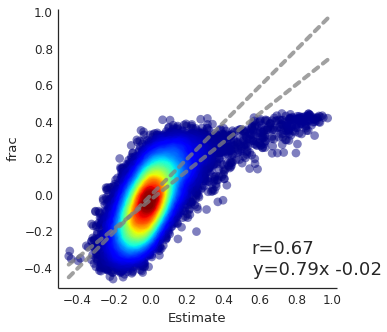

In [297]:
plot_regression_density(pcna_genes['Estimate'], dx_rna.frac - .5, rad=.05)

In [36]:
rna_sig.name = 'f'

In [88]:
rr = screen_feature(meta_pcna, pearson_pandas, rna_df.xs('01',1,1))

In [373]:
standardize = lambda s: s.sub(s.median(1), axis=0).div(s.mad(1), axis=0)
df = rna_df.xs('01',1,1)
df_s = df.groupby(codes, axis=1).apply(standardize)
mp2 = meta_pcna.groupby(codes).apply(standardize)

In [374]:
pcna_corr = df_s.T.corrwith(mp2)

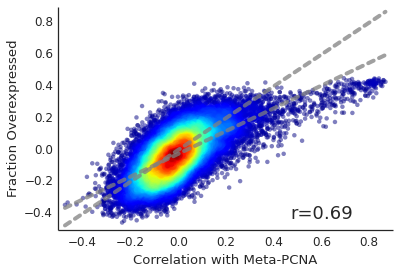

In [376]:
fig, ax = subplots()
f = pcna_corr
plot_regression(f, dx_rna.frac - .5, density=True, rad=.03, s=20,
                rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ylabel('Fraction Overexpressed')
ax.set_xlabel('Correlation with Meta-PCNA')

In [377]:
def detrend(x,y):
    x, y = match_series(x, y)
    reg = linear_regression(x, y)
    #adj = (x * reg['slope']) + reg['intercept']
    adj = (y - reg['intercept']) / reg['slope']
    return adj

In [378]:
f_adj = pcna_corr.ix[ti(pcna_corr < .4)].dropna()
f_adj = detrend(f_adj, dx_rna.frac)
f_adj = f_adj - pcna_genes.Estimate
f_adj = f_adj.dropna()
#f_adj = f_adj.ix[ti(pcna_genes.Estimate < .35)].dropna()

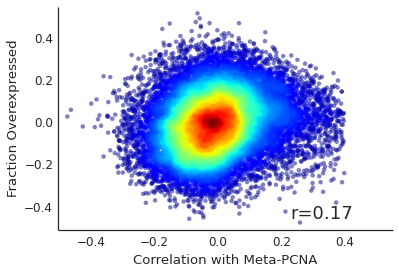

In [379]:
fig, ax = subplots()
plot_regression(pcna_corr, f_adj, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ylabel('Fraction Overexpressed')
ax.set_xlabel('Correlation with Meta-PCNA')

In [400]:
dx_rna.ix['HIST2H2AA3']

num_ox    5.30e+02
num_dx    6.69e+02
frac      7.92e-01
p         1.22e-54
Name: HIST2H2AA3, dtype: float64

In [399]:
pcga_corr.ix['HIST2H2AA3']

0.012046507540242495

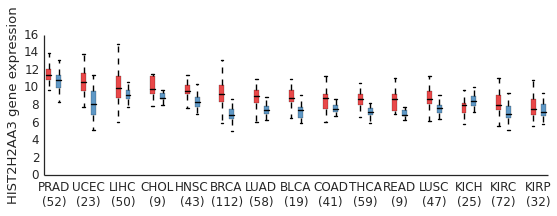

In [398]:
paired_bp_tn_split(rna_df.ix['HIST2H2AA3'], codes)

In [380]:
gs2 = gene_sets.ix[f_adj.index].fillna(0)
r2 = screen_feature(f_adj, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * f_adj).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

In [381]:
r2.ix[ti(fp > 0)].join(fp).sort('p').head(6)

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_METABOLISM_OF_PROTEINS,86.25,1.58e-20,2.11e-17,0.06
REACTOME_RNA_POL_I_PROMOTER_OPENING,57.91,2.75e-14,1.83e-11,0.16
REACTOME_RNA_POL_I_TRANSCRIPTION,53.26,2.92e-13,1.30e-10,0.12
REACTOME_DEPOSITION_OF_NEW_CENPA_CONTAINING_NUCLEOSOMES_AT_THE_CENTROMERE,48.15,3.94e-12,1.08e-09,0.16
REACTOME_RNA_POL_I_RNA_POL_III_AND_MITOCHONDRIAL_TRANSCRIPTION,48.10,4.06e-12,1.08e-09,0.10
REACTOME_PACKAGING_OF_TELOMERE_ENDS,47.66,5.08e-12,1.13e-09,0.17


In [384]:
r2.ix[ti(fp < 0)].join(fp).sort('p').head()

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_SIGNALING_BY_GPCR,29.62,5.25e-08,3.24e-06,-0.03
KEGG_FATTY_ACID_METABOLISM,29.58,5.36e-08,3.24e-06,-0.13
KEGG_PROPANOATE_METABOLISM,29.35,6.04e-08,3.49e-06,-0.14
REACTOME_BIOLOGICAL_OXIDATIONS,26.75,2.31e-07,1.23e-05,-0.06
KEGG_DRUG_METABOLISM_CYTOCHROME_P450,26.55,2.56e-07,1.26e-05,-0.09


In [ ]:
patient_switch = df_s.corrwith(f_adj)
patient_switch = patient_switch.groupby(codes).apply(standardize)

In [605]:
mut_all = pd.read_csv('/cellar/users/agross/TCGA_Code/CancerData/Data/MAFs_new_4/meta.csv', 
                      index_col=[1,2])
mut = mut_all['0'].unstack().fillna(0)
mut = FH.fix_barcode_columns(mut)
mut = mut.xs('01', axis=1, level=1)

In [ ]:
mut = mut.ix[rna_df.index]
mut_rate = (mut>0).mean().order()
mut = mut.ix[:, ti(mut_rate < .1)] #filter samples with lots of mutations
mut.shape

In [ ]:
df = mut[(mut > 0).sum(1) > 30]
df.shape

In [ ]:
c

In [521]:
rr = screen_feature(patient_switch, rev_kruskal, df>0, align=False)

In [522]:
rr.head(10)

,H,p,q
BAP1,25.51,4.41e-07,0.00
MCTP1,22.71,1.88e-06,0.01
CDK17,22.51,2.09e-06,0.01
ERMP1,17.04,3.67e-05,0.10
RIMS2,16.37,5.21e-05,0.11
CCDC108,15.69,7.47e-05,0.14
LAMB2,15.32,9.08e-05,0.14
PGR,15.11,1.02e-04,0.14
PPP2R2A,14.80,1.19e-04,0.14
PGBD5,14.49,1.41e-04,0.15


In [574]:
(rr.p < .005).value_counts()

False    10801
True       140
dtype: int64

In [600]:
ptw = ti(gs2.ix[ti(rr.p < .01)].sum() > 4)
ptw.shape

(53,)

In [601]:
r2 = screen_feature(rr.p < .01, fisher_exact_test, gs2[ptw].T>0)

In [602]:
r2.head()

,odds_ratio,p,q
REACTOME_SIGNALING_BY_FGFR,5.53,2.20e-04,0.01
KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION,6.26,2.72e-04,0.01
KEGG_CHEMOKINE_SIGNALING_PATHWAY,4.27,5.30e-04,0.01
REACTOME_SIGNALING_BY_FGFR_IN_DISEASE,4.68,6.11e-04,0.01
REACTOME_DOWNSTREAM_SIGNALING_OF_ACTIVATED_FGFR,5.15,7.81e-04,0.01


In [603]:
pd.crosstab(gs2['REACTOME_SIGNALING_BY_FGFR']>0,
                  rr.p < .01)

p,False,True
REACTOME_SIGNALING_BY_FGFR,,
False,9648,229
True,61,8


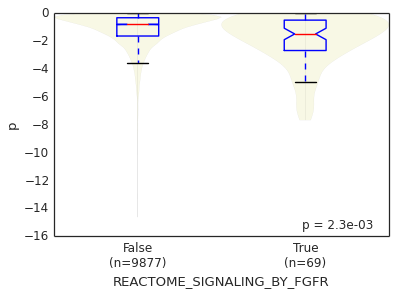

In [604]:
violin_plot_pandas(gs2['REACTOME_SIGNALING_BY_FGFR']>0, np.log(rr.p))

In [492]:
cn = FH.get_gistic_gene_matrix(run.data_path, 'HNSC')

In [493]:
bap1 = cn.xs('NCKAP1', level=2).iloc[0]

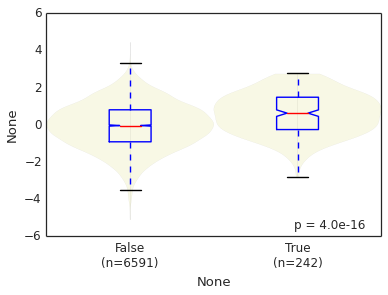

In [530]:
violin_plot_pandas((mut.ix[['BAP1','CDK17','MCTP1']] > 0).sum()>0, patient_switch)

In [435]:
anova(mut.ix['KRAS']>0, patient_switch)

F    6.03
p    0.01
dtype: float64

In [415]:
get_cox_ph_ms(surv_5y, patient_switch.ix[keepers], [meta_pcna, codes, age], 
              interactions=False)

LR                                                     0.00469
feature_p                                              0.00483
fmla         Surv(days, event) ~ feature + meta_pcna + code...
hazzard                                                      2
dtype: object

In [397]:
f_adj.ix[ti(gs2['REACTOME_PACKAGING_OF_TELOMERE_ENDS']>0)].order()

TINF2        -0.11
TERF1        -0.08
TERF2IP      -0.06
HIST1H4C     -0.03
TERF2        -0.01
HIST2H2AC     0.03
ACD           0.07
HIST1H4B      0.08
HIST1H4D      0.11
HIST1H2BJ     0.12
POT1          0.12
HIST1H2AB     0.13
HIST1H2BH     0.13
HIST1H4I      0.15
HIST1H2BL     0.15
HIST1H2BO     0.15
HIST1H4A      0.15
HIST1H2AD     0.17
HIST1H2BI     0.18
HIST2H2BE     0.18
HIST4H4       0.19
HIST1H2BC     0.20
HIST2H4A      0.20
HIST1H2AC     0.21
HIST1H4E      0.22
HIST1H2BG     0.22
HIST1H4H      0.22
HIST1H2AJ     0.23
HIST1H2BF     0.23
HIST1H2BN     0.26
HIST1H2AE     0.27
HIST1H2BM     0.27
HIST1H2BK     0.27
HIST3H2BB     0.27
HIST1H2BE     0.27
HIST1H2BD     0.30
HIST1H4K      0.32
HIST1H4J      0.35
HIST2H2AA3    0.38
dtype: float64

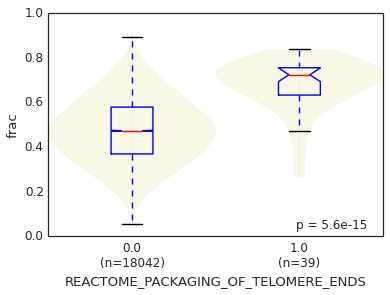

In [388]:
violin_plot_pandas(gs2['REACTOME_PACKAGING_OF_TELOMERE_ENDS'], dx_rna.frac.dropna())

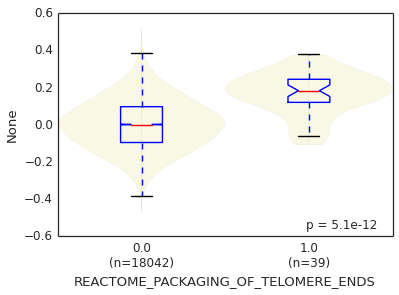

In [389]:
violin_plot_pandas(gs2['REACTOME_PACKAGING_OF_TELOMERE_ENDS'], f_adj.dropna())

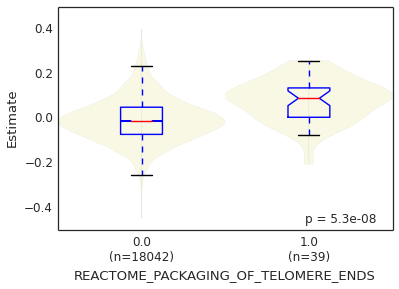

In [390]:
violin_plot_pandas(gs2['REACTOME_PACKAGING_OF_TELOMERE_ENDS'], pcna_genes.Estimate.dropna())

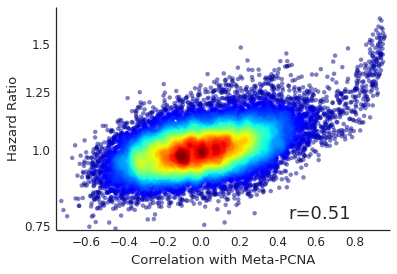

In [64]:
fig, ax = subplots()
f = rr.rho
plot_regression(f, pancan_haz, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ybound(-.3,.55)
ax.set_yticks(np.log([.75, 1, 1.25, 1.5]))
ax.set_yticklabels(np.round(np.exp(ax.get_yticks()), 2))
ax.set_ylabel('Hazard Ratio')
ax.set_xlabel('Correlation with Meta-PCNA')

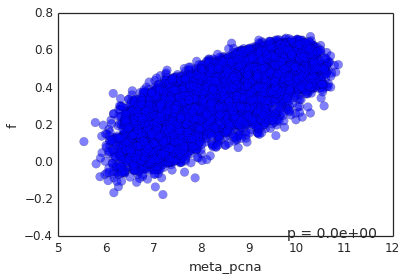

In [56]:
series_scatter(meta_pcna, rna_sig)

In [46]:
f = 'Surv(days, event) ~ meta_pcna + f + codes'

In [49]:
get_cox_ph(surv_5y, covariates=[meta_pcna, rna_sig, codes], formula=f, 
           interactions=False, print_desc=True);


            coef exp(coef) se(coef)     z    p
meta_pcna 0.3481      1.42   0.0382 9.102 0.00
f         0.0168      1.02   0.0397 0.422 0.67

Likelihood ratio test=236  on 2 df, p=0  n= 8478, number of events= 1889 



RNA proliferation signature

In [9]:
rna_sig = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                      index_col=[0,1], header=None, squeeze=True)
rna_sig = rna_sig[:,1]
rna_sig.index.name = ''

In [40]:
f = meta_pcna.copy()
f = (f - f.mean()) / f.std()
f.name = 'feature'
codes_f = codes.ix[(codes.index.intersection(f.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
codes_f.name = 'codes'
m = get_cox_ph(surv_5y, f, [age, old, stage, codes_f], 
               print_desc=False, interactions=False)
ci = convert_robj(robjects.r.summary(m)[7])
ci.index = ci.index.map(lambda s: s.replace('codes', ''))
ci.index = ci.index.map(lambda s: s.replace('stagestage', 'stage'))
pancan_ci = ci.ix['feature']
pancan_ci.name = 'PANCAN'

In [41]:
v = meta_pcna
ci = {}
for c in codes.unique():
    try:
        pts = ti(codes == c)
        f = v.ix[pts].dropna()
        cov = [b.ix[pts].dropna() for b in [old, age] if 
               b.ix[pts].dropna().unique().shape[0] > 1]
        f = (f - f.mean()) / f.std()
        f.name = 'featue'
        ff = ' + '.join(['feature'] + [b.name for b in cov])
        formula = robjects.Formula('Surv(days, event) ~ ' + ff)
        m1 = get_cox_ph(surv_5y, f, covariates=cov, formula=formula,
                        print_desc=False, interactions=False);
        ci[c] = convert_robj(robjects.r.summary(m1)[7])
    except:
        print c
cc = pd.concat(ci).xs('feature', level=1)
cc = cc.sort('exp(coef)', ascending=False)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]

STAD
ESCA
LAML


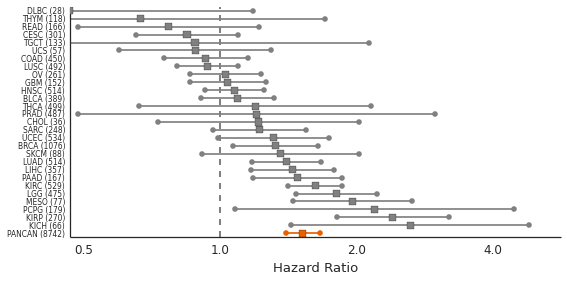

In [42]:
fig, ax = subplots(figsize=(8,4))
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label, fontsize=7.5);
ax.set_xlabel('Hazard Ratio')
fig.tight_layout()

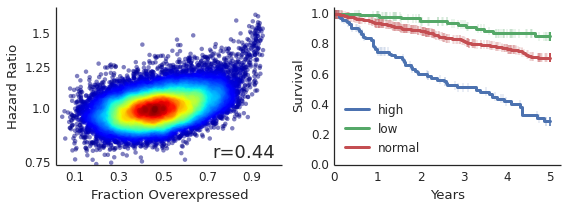

In [61]:
fig, axs = subplots(1,2, figsize=(8,3))
ax = axs[0]
f = dx_rna.frac
plot_regression(f - .5, pancan_haz, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ybound(-.3,.55)
ax.set_yticks(np.log([.75, 1, 1.25, 1.5]))
ax.set_yticklabels(np.round(np.exp(ax.get_yticks()), 2))
ax.set_ylabel('Hazard Ratio')
ax.set_xticklabels(ax.get_xticks() + .5)
ax.set_xlabel('Fraction Overexpressed')

ax = axs[1]
pts = ti(codes.str.startswith('K')).intersection(ti(age < 85))
draw_survival_curve(to_quants(rna_sig.ix[pts].dropna(), std=1, labels=True), 
                    surv_5y, ax=ax)
prettify_ax(ax)
fig.tight_layout()

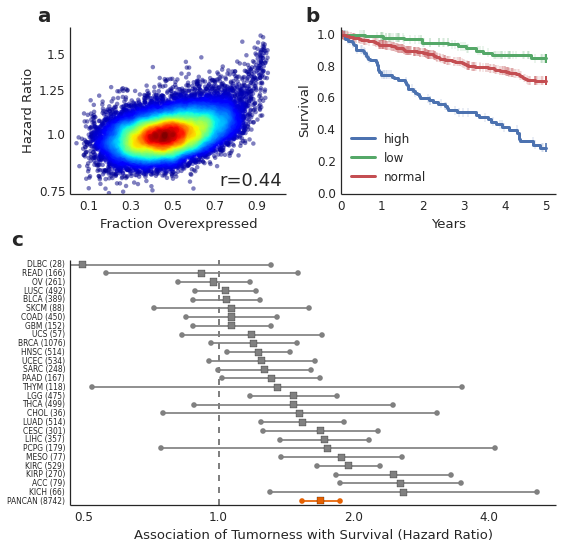

In [62]:
fig = plt.figure(figsize=(8, 7.5))
ax1 = plt.subplot2grid((7, 2), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((7, 2), (0, 1), rowspan=3)
ax3 = plt.subplot2grid((7, 2), (3, 0), colspan=2, rowspan=4)

ax = ax1
f = dx_rna.frac
plot_regression(f - .5, pancan_haz, density=True, rad=.03, s=20,
                line_args={'lw':0}, rasterized=True, ax=ax)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ybound(-.3,.55)
ax.set_yticks(np.log([.75, 1, 1.25, 1.5]))
ax.set_yticklabels(np.round(np.exp(ax.get_yticks()), 2))
ax.set_ylabel('Hazard Ratio')
ax.set_xticklabels(ax.get_xticks() + .5)
ax.set_xlabel('Fraction Overexpressed')

ax = ax2
pts = ti(codes.str.startswith('K')).intersection(ti(age < 85))
draw_survival_curve(to_quants(rna_sig.ix[pts].dropna(), std=1, labels=True), 
                    surv_5y, ax=ax)
prettify_ax(ax)

ax = ax3
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label, fontsize=7.5);
ax.set_xlabel('Association of Tumorness with Survival (Hazard Ratio)')

letters = list(map(chr, range(97, 123)))[:6] 
for i,ax in enumerate([ax1, ax2, ax3]):
    ax.text(-0.1, 1.12, letters[i], transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='right')
fig.tight_layout(pad=1.3, h_pad=3)
fig.savefig('/cellar/users/agross/Desktop/Figures/DX_fig2.png', dpi=300,
            bbox_inches='tight')